# PaMoDaCo: CMIP6-LMR & eVolv2k

_Scientific Context:_ Compare simulations from the Last Millennium Reanalysis project to physics based model output from the last thousand years and compare to the timing of major volcanic events. 

_Tech Objective:_ Learn how to process and present multiple large datasets more efficiently and without hosting them locally. 

- use Pangeo-Forge cloud-optimized datasets rather than locally hosted data to reduce needed compute resources
- use `chunking` and `ThreadPool` to speed up parallelizable data processing
- use Xarray to process spatial model output into de-seasonalized, annualized, latitude-weighted global mean air temperature
- plot model simulations on top of envelope of ensemble simulations and juxtapose to major volcanic events

Per usual, first we'll load packages we will need.

In [2]:
%load_ext autoreload
%autoreload 2

import xarray as xr
from pathlib import Path
import numpy as np
import cftime
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec

import pyleoclim as pyleo
from multiprocessing.pool import ThreadPool as Pool
import time

# Cloud-ready data

### Pangeo-Forge
Loading model output, even if only to pull a subset, can be somewhere between challenging and impossible on the average personal computer. Happily, folks at [Pangeo-Forge](https://pangeo-forge.org) have made it their mission to help by developing some infrastructure to make large datasets often stored in multiple parts available in clean consolidated form via a simple URL. 

### How it works
Members of the Pangeo-Forge community develop and contribute "recipes" that provide instructions about where to find the various parts of a dataset, how to stitch them together, and potentially how to tidy up label names and other matters of convenience. When a user wants to use one of the datasets with a recipe on file, Pangeo-Forge system (the bots are quite friendly!) run that recipe and the dataset becomes temporarily available from the Pangeo-Forge cache. One of the delightfully efficient aspects of the whole operation is that recipes are tiny to store, so the catalog can theoretically grow pleasantly large without impinging on the memory needed to serve up the actual datasets. The datasets remain "on call" as long as they are being accessed relatively frequently. Once the usage rate drops, the dataset is released to free up space, but is still available by request. 

#### Datasets on tap
Feel free to puruse the catalog [here](https://pangeo-forge.org/catalog), and if you have an idea for a dataset that would benefit from being hosted in the cloud, let us know!


## Data
We'll load datasets cloud hosted by [Pangeo-Forge](https://pangeo-forge.org/) using [Xarray](https://xarray.dev/).


#### Last Millennium Reanalysis Project (LMR)

The LMR project was based on the notion that we have some sense of the various states the climate can exist in, and some imperfect sense that climate proxies reflect these variations. 
These painfully reconstructed  proxy records from various natural archives are a bit like a lossy game of telephone: they provide information in a sequence (mostly), and that information is communicated in discernible syllables from a language we can identify. We don't know the dialect, and there may be other noise in the room, but given an idea of what the original speaker was likely to know, we can scrape together a set of words that are most likely. 

The concept behind LMR is similar. We have enough information about climate over the last millennium that we can amass a set of snapshots that describe different states the climate has likely inhabited. We also have a mapping of sorts between climate variables and archive-specific proxy values. If we apply this mapping to the snapshots, we get a set of simulated proxy values--the values the archives might have recorded in response to the snapshots. Then we can use the simulated proxy values to calculate the likelihood that each climate snapshot corresponds to a given measured proxy value. 

As a practical matter, each simulation starts with a sample of 100 climate snapshots (members), and 75% of the catalog of natural archive data. Proxy measurements for each year are used to establish the likelihood of each climate snapshot. For a given variable (e.g. precipitation), the value reported for each member reflects the composite of the original variable value for that member and the likelihood weight, but in cases where members are not reported individually, the reported simulation summary value is the mean. By doing this many times (different 100 snapshot pools with different subsets of proxy data) we can build a picture of how the last millennium climate story may have unfolded, without dismissing uncertainty (which may hold unappreciated insight). 

Needless to say, there is a bunch of math behind every step which is described at much greater length elsewhere (for example, Hakim et al, 2016). 

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Hakim, G. J., Emile-Geay, J., Steig, E. J., Noone, D., Anderson, D. M., Tardif, R., Steiger, N., and Perkins, W. A. (2016), The last millennium climate reanalysis project: Framework and first results, J. Geophys. Res. Atmos., 121, 6745– 6764, doi:10.1002/2016JD024751.|
| Tardif, R., Hakim, G. J., Perkins, W. A., Horlick, K. A., Erb, M. P., Emile-Geay, J., Anderson, D. M., Steig, E. J., and Noone, D.: Last Millennium Reanalysis with an expanded proxy database and seasonal proxy modeling, Clim. Past, 15, 1251–1273,  https://doi.org/10.5194/cp-15-1251-2019 , 2019. |



##### Loading data
We'll load datasets using **[Xarray](https://xarray.dev/)**. Xarray is specifically designed to accommodate multidimensional data, like that from a NetCDF file, or in this case a zarr file (another multidimensional data file type that is somewhat slimmer).


The ungridded output from the Last Millennium Reanalysis Project is (happily) available via Pangeo-Forge. 



In [3]:
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1409/LMRv2p1_MCruns_ensemble_ungridded.zarr"
lmr_ds_ungridded = xr.open_dataset(store, engine='zarr', chunks={}, use_cftime=True)
lmr_ds_ungridded

<xarray.Dataset>
Dimensions:              (time: 2001, MCrun: 20, members: 100, lat: 24, lon: 81)
Coordinates:
  * lat                  (lat) float32 20.0 22.0 24.0 26.0 ... 62.0 64.0 66.0
  * lon                  (lon) float32 100.0 102.0 104.0 ... 256.0 258.0 260.0
  * time                 (time) object 0000-01-01 00:00:00 ... 2000-01-01 00:...
Dimensions without coordinates: MCrun, members
Data variables:
    amo                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    ao                   (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    ensmean_pdo_idx      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ensmean_pdo_pattern  (lat, lon) float32 dask.array<chunksize=(24, 81), meta=np.ndarray>
    gmt                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    nao                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    nhmt                 (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    nino34               (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    pdo                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    sam                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    shmt                 (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    soi                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
Attributes:
    comment:                   File contains full ensemble values for each Mo...
    description:               Last Millennium Reanalysis climate field recon...
    experiment:                productionFinal2_gisgpcc_ccms4_LMRdbv1.1.0_tas
    pangeo-forge:inputs_hash:  51192b3d1b2a5bf9297cd3e6d03e1f98e202d6571545d5...
    pangeo-forge:recipe_hash:  c41d1ef8f142f43547e95f9e75160849d7554e2afaad4e...
    pangeo-forge:version:      0.9.2

##### Process member data to traces
The ungridded output includes 20 Monte Carlo simulations. For each Monte Carlo simulation there are values associated with 100 members that for each time step. 

In the cell below we:
1. Group the data by Monte Carlo run
2. For each Monte Carlo run we calculate the average value of global mean temperature for the members for each year, and save a corresponding Pyleoclim Series in a list

> Tech note: The cell below may take a minute or two to run.  Another useful aspect of Pangeo-Forge is that it returns data in structures designed to keep the memory footprint of data low.  Without going into great detail (if you want to go for a ride, start reading about `Dask`), this means that data doesn't sit quietly as an array but rather resides in number of `chunks` that can be accessed for computation. In many cases, this is invisible to the user (except for being faster), but sometimes (particularly after slicing and dicing data) it is helpful to change how the chunks are structured. In the loop below we use `.chunk()` to change the chunk schema to one chunk per timeseries. This would not have been optimal when dealing with the whole dataset with its 100 members per year, per variable, per Monte Carlo simulation for 2001 years and 20 Monte Carlo simulations, but once we reduce the selected data to one Monte Carlo simulation and one variable, it is tractable to have the entire timeseries in one chunk, and loads more easily into the Pyleoclim timeseries.

In [4]:
%%time

MCrun_grps = [grp for grp in lmr_ds_ungridded.groupby('MCrun')]
es_ps = []
def f(MCrun_grp):
    rechunked = MCrun_grp[1]['gmt'].chunk({'time':1})
    MCrun = rechunked.groupby('time.year').mean('members')
    ps = pyleo.Series(MCrun.time.dt.year.data, MCrun.data, time_unit='year', clean_ts=False, value_name='MCrun {}'.format(MCrun_grp[0]))
    return ps

# this takes twice as long with only one thread (9 ish minutes v. 5 ish minutes)
pool = Pool(8)
for result in pool.imap_unordered(f, MCrun_grps):
    es_ps.append(result)


CPU times: user 4min 27s, sys: 27.5 s, total: 4min 55s
Wall time: 6min 8s


In [5]:
lmr_ens = pyleo.EnsembleSeries(es_ps)

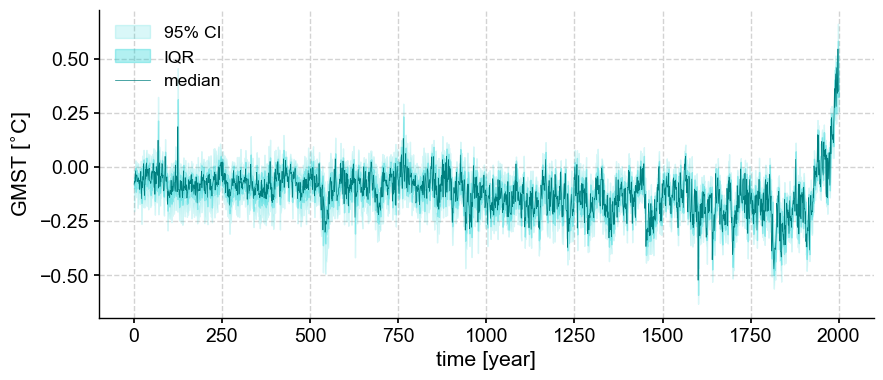

In [39]:
fig, ax = lmr_ens.plot_envelope( shade_alpha = .15,  ylabel='GMST [$^{\\circ}$C]', curve_lw=.5, shade_clr = 'darkturquoise', curve_clr='teal')

This is an interesting look at how we calculate these trajectories. The real power of these simulations lies in looking at MANY of them. Let's load a set of 1000 traces and compare the envelopes. These simulation traces are calculated according to the same methodology, applied to a subset of natural archive records. While the set of 20 considered above isn't an explicit subset of the 1000 we will look at below, they are close enough cousins to make a reasonable case for the value of looking at 1000 iterations. 

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  Zhu, F., Emile-Geay, J., Hakim, G. J., King, J., & Anchukaitis, K. J. (2020). Resolving the differences in the simulated and reconstructed temperature response to volcanism. Geophysical Research Letters, 47, e2019GL086908. https://doi.org/10.1029/2019GL086908 |


In [9]:
file_path = '../data/p2k_ngeo19_recons.nc'
p2k_nc = xr.open_dataset(file_path)
p2k_nc

<xarray.Dataset>
Dimensions:  (year: 2000, ens: 1000)
Coordinates:
  * year     (year) int64 1 2 3 4 5 6 7 8 ... 1994 1995 1996 1997 1998 1999 2000
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 ... 993 994 995 996 997 998 999 1000
Data variables:
    LMRv2.1  (year, ens) float32 ...
    BHM      (year, ens) float64 ...
    DA       (year, ens) float64 ...
    CPS_new  (year, ens) float64 ...
    CPS      (year, ens) float64 ...
    OIE      (year, ens) float64 ...
    PAI      (year, ens) float64 ...
    PCR      (year, ens) float64 ...
    M08      (year, ens) float64 ...

In [10]:
variable_name = 'LMRv2.1'
ens_grps = p2k_nc.groupby('ens')
ts_list = []

for im in range(len(p2k_nc.ens)):
    ens_run = ens_grps[im+1].data_vars[variable_name]
    ts_list.append(pyleo.Series(time=p2k_nc.year, value=ens_run,
                      time_name='Time', time_unit='year',
                      value_name='GMST', value_unit='$^{\circ}$C'))



In [11]:
lmr_ens2 = pyleo.EnsembleSeries(ts_list)

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'Default'}, xlabel='Time [year]', ylabel='GMST [$^{\\circ}$C]'>)

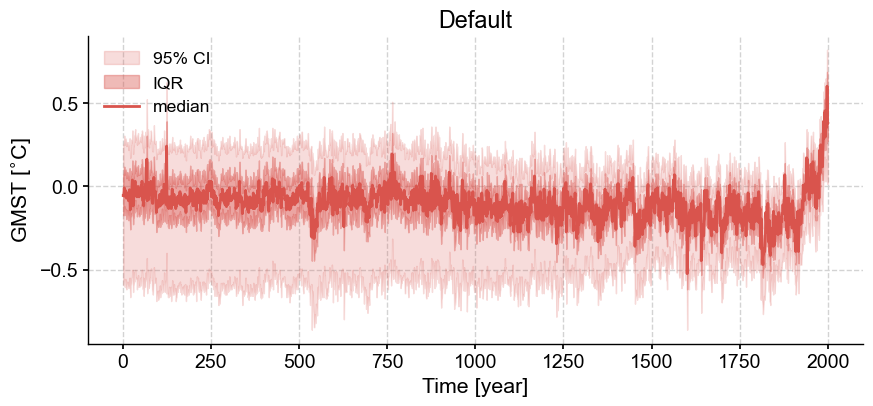

In [12]:
lmr_ens2.plot_envelope(title='Default') 

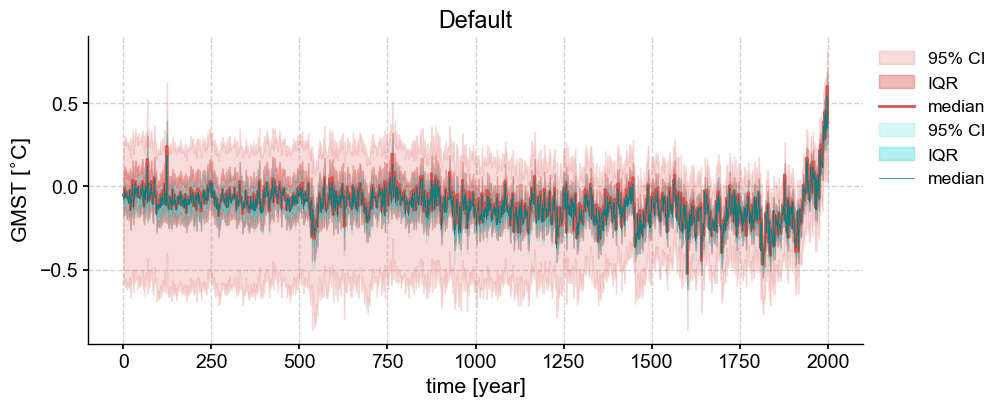

In [28]:
fig, ax = lmr_ens2.plot_envelope(title='Default') 
lmr_ens.plot_envelope( shade_alpha = .15,  ylabel='GMST [$^{\\circ}$C]', curve_lw=.5, ax=ax, shade_clr = 'darkturquoise', curve_clr='teal')
ax.legend(bbox_to_anchor=(1,1))

#### CMIP6

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Kageyama, M., Braconnot, P., Harrison, S. P., Haywood, A. M., Jungclaus, J. H., Otto-Bliesner, B. L., Peterschmitt, J.-Y., Abe-Ouchi, A., Albani, S., Bartlein, P. J., Brierley, C., Crucifix, M., Dolan, A., Fernandez-Donado, L., Fischer, H., Hopcroft, P. O., Ivanovic, R. F., Lambert, F., Lunt, D. J., Mahowald, N. M., Peltier, W. R., Phipps, S. J., Roche, D. M., Schmidt, G. A., Tarasov, L., Valdes, P. J., Zhang, Q., and Zhou, T.: The PMIP4 contribution to CMIP6 – Part 1: Overview and over-arching analysis plan, Geosci. Model Dev., 11, 1033–1057, https://doi.org/10.5194/gmd-11-1033-2018, 2018.|


In [13]:
def align_time_index(ds, shift=0):
    # shift time axis if needed
    new_index = xr.CFTimeIndex(ds['time'].values).shift(shift*12, 'M')
    new_index_ds = ds.assign_coords(time=new_index)
    return new_index_ds

def remove_seasonality(ds):
    climatology = ds.chunk({'time':1}).groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies

def global_mean(ds, lat_weighted=False):
    if lat_weighted is True:
        lat_weights = np.cos(np.deg2rad(ds.lat))
        lat_weights.name = "lat_weights"

        ds_lat_weighted = ds.weighted(lat_weights)
        ds_global_mean = ds_lat_weighted.mean(("lon", "lat"))
    else:
        ds_global_mean = ds.mean(("lon", "lat"))
    return ds_global_mean

def annualize(ds):
    ds_annualized = ds.groupby('time.year').mean('time')
    return ds_annualized
    

##### MIROC

In [14]:
store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/CMIP6-PMIP-feedstock/CMIP6.PMIP.MIROC.MIROC-ES2L.past1000.r1i1p1f2.Amon.tas.gn.v20200318.zarr'
miroc = xr.open_dataset(store, engine='zarr', chunks={}, use_cftime=True)

In [15]:
%%time
miroc_anom_lat_wm_annual = annualize(global_mean(remove_seasonality(align_time_index(miroc, shift=0)), lat_weighted=True).compute())
miroc_year_wm_ps = pyleo.Series(miroc_anom_lat_wm_annual.year, miroc_anom_lat_wm_annual.tas, time_unit='year', 
                                clean_ts=False, value_name='Temp anomaly ($^{\circ}$C)')#atm temp @2m')

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1001 times more chunks
  return self.array[key]


CPU times: user 2min 13s, sys: 14.1 s, total: 2min 27s
Wall time: 18min 36s


##### MRI

In [16]:
store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/CMIP6-PMIP-feedstock/CMIP6.PMIP.MRI.MRI-ESM2-0.past1000.r1i1p1f1.Amon.tas.gn.v20200120.zarr'
mri = xr.open_dataset(store, engine='zarr', chunks={}, use_cftime=True)


In [17]:
%%time
mri_anom_lat_wm_annual = annualize(global_mean(remove_seasonality(align_time_index(mri, shift=0)), lat_weighted=True).compute())
mri_year_wm_ps = pyleo.Series(time=mri_anom_lat_wm_annual.year, value=mri_anom_lat_wm_annual.tas, time_unit='year', 
                              clean_ts=False, value_name='Temp anomaly ($^{\circ}$C)')

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]


CPU times: user 2min 33s, sys: 26.2 s, total: 3min
Wall time: 3min 4s


##### MPI

In [18]:
store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/CMIP6-PMIP-feedstock/CMIP6.PMIP.MPI-M.MPI-ESM1-2-LR.past2k.r1i1p1f1.Amon.tas.gn.v20210714.zarr'
mpi = xr.open_dataset(store, engine='zarr', chunks={}, use_cftime=True)

In [19]:
%%time
mpi_anom_lat_wm_annual = annualize(global_mean(remove_seasonality(align_time_index(mpi, shift=-7000)), lat_weighted=True).compute())
mpi_year_wm_ps = pyleo.Series(mpi_anom_lat_wm_annual.year, mpi_anom_lat_wm_annual.tas, time_unit='year', 
                              clean_ts=False, value_name='Temp anomaly ($^{\circ}$C)')#atm temp @2m')


/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1850 times more chunks
  return self.array[key]


CPU times: user 4min 5s, sys: 32.4 s, total: 4min 37s
Wall time: 4min 58s


## Volcanic Sulfates

Volcanic eruptions inject various aerosols into the atmosphere, affecting the radiation budget of the earth. Let's load up a timeseries of reconstructed stratospheric sulfates and visualize it next to our air temperature data. 

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|Toohey, M. and Sigl, M.: Volcanic stratospheric sulfur injections and aerosol optical depth from 500 BCE to 1900 CE, Earth Syst. Sci. Data, 9, 809–831, https://doi.org/10.5194/essd-9-809-2017, 2017.|

In [20]:
vol_ds = xr.open_dataset(Path(os.getcwd()).parent/'data'/'eVolv2k_v3_ds_1.nc')
vol_ps_yr = pyleo.Series(vol_ds['year'], vol_ds.vssi, time_unit='year', clean_ts=False, value_name='volcanic sulfates')


In [22]:
# these are the best hits, sure to yield a rocking good time...
top_40 = vol_ds.sortby('vssi', ascending=False).head(40)
top_40

<xarray.Dataset>
Dimensions:     (nerup: 40)
Dimensions without coordinates: nerup
Data variables:
    year        (nerup) float64 1.257e+03 -425.0 -43.0 ... -246.0 1.191e+03
    yearCE      (nerup) float64 ...
    month       (nerup) float64 ...
    day         (nerup) float64 ...
    lat         (nerup) float64 ...
    vssi        (nerup) float64 59.42 59.33 38.56 32.98 ... 9.34 8.87 8.84 8.53
    hemi        (nerup) float64 ...
    sigma_vssi  (nerup) float64 ...
Attributes:
    title:      Ice core-inferred volcanic stratospheric sulfur injection (VS...
    history:    Created Thu Jul 11 16:51:32 2019
    reference:  Toohey and Sigl (2017) doi:10.5194/essd-9-809-2017
    comment:    Minor update from v2, includes reassignment of eruption regio...

### Envelope of LMR simulations with CMIP6 output and major volcanic events

(0.0, 2000.0)

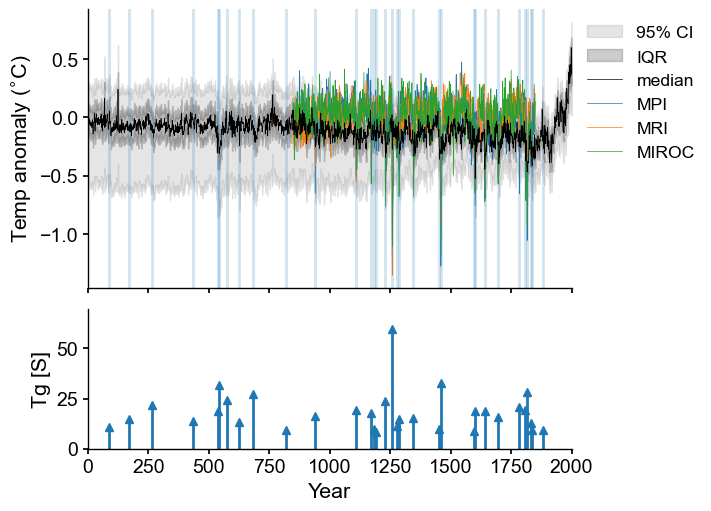

In [40]:
# Create a figure with a gridspec layout to allow us to have two differently sized subplots with a shared x-axis.
fig = plt.figure(figsize=(7, 5), layout="constrained")
spec = fig.add_gridspec(6, 1, hspace=.20)#, sharex=True)

ax1 = fig.add_subplot(spec[4:, :])
ax2 = fig.add_subplot(spec[:4, :])

# Bottom stem plot of a set of prominent volcanic events 
ax1.stem(top_40.year, top_40.vssi, markerfmt='^', basefmt=' ')
ax1.grid(False)
ax1.set_ylim([0, vol_ds.vssi.max()+10])
ax1.set_ylabel('Tg [S]')
ax1.set_xlabel('Year')

# Same EnsembleSeries envelope from above, this time with lines that correspond to volcanic events
lmr_ens2.plot_envelope( shade_alpha = .1,  ylabel='GMST [$^{\circ}$C]', 
                                                   curve_lw=.5, shade_clr='k', curve_clr='k', ax=ax2)
mpi_year_wm_ps.slice([850, 1850]).plot(ax=ax2, label='MPI', linewidth=.5)
mri_year_wm_ps.slice([850, 1850]).plot(ax=ax2, label='MRI', linewidth=.5)
miroc_year_wm_ps.slice([850, 1850]).plot(ax=ax2, label='MIROC', linewidth=.5)

for time in top_40.year.data:
    ax2.axvline(x=time, alpha=.2)
    
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xticklabels([])
ax2.set_xlabel('')
ax2.grid(False)
ax2.legend(bbox_to_anchor = (1,1))

xlims = [lmr_ds_ungridded.time.dt.year.min(), lmr_ds_ungridded.time.dt.year.max()]
ax1.set_xlim(xlims)
ax2.set_xlim(xlims)


### Summary